In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy


sc.set_figure_params(figsize=(4, 4))

In [2]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

# FEMALE

### Read in Sanger dataset

In [3]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
sanger = sc.read(path_to_gonads + 'mouse-gonads_rawcounts.h5ad')

In [4]:
sanger = sanger[['female' in i for i in sanger.obs.sex]]
sanger.X.shape

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(31862, 24482)

### Read in Niu dataset

In [5]:
niu = sc.read('/nfs/team292/vl6/Mouse_Niu2020/mouse_annotated.h5ad')
niu = anndata.AnnData(X=niu.raw.X, var=niu.raw.var, obs=niu.obs, asview=False)

In [6]:
sanger.obs['dataset'] = 'Sanger'
niu.obs['dataset'] = 'Niu2020'
niu.obs['sex'] = 'female'
niu.obs['location'] = 'gonad'
adata = sanger.concatenate(niu,
                    batch_key = 'dataset', 
                batch_categories = ['Sanger', 'Niu2020'], 
                                  join = 'outer')

Trying to set attribute `.obs` of view, copying.


In [7]:
sc.pp.filter_genes(adata, min_counts=3)

In [8]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/mouse-gonads_females_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

# metaF.index = [i+"-Sanger" for i in metaF.index]
cell_annot = metaF['lineage'].to_dict()
adata.obs['lineage_previous'] = adata.obs_names.map(cell_annot).astype('category')

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (11,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# Import predictions from SVM
meta = pd.read_csv('/nfs/team292/vl6/Mouse_Sanger/SVM_females_probs.csv')
meta = meta.set_index('Unnamed: 0')
meta.head()

dfnames = meta.columns.tolist()

for clname in dfnames:
    cell_annot = meta[clname].to_dict()
    adata.obs[clname] = adata.obs_names.map(cell_annot)

adata.obs.head()

n_genes            sample stage  \
HCA_Mou_10828699_AAACCTGAGATCACGG-Sanger     5003  HCA_Mou_10828699  12.5   
HCA_Mou_10828699_AAACCTGAGCCACCTG-Sanger     5365  HCA_Mou_10828699  12.5   
HCA_Mou_10828699_AAACCTGAGGCGTACA-Sanger     3916  HCA_Mou_10828699  12.5   
HCA_Mou_10828699_AAACCTGAGTGAAGTT-Sanger     4712  HCA_Mou_10828699  12.5   
HCA_Mou_10828699_AAACCTGAGTGTTGAA-Sanger     5106  HCA_Mou_10828699  12.5   

                                             sex location  percent_mito  \
HCA_Mou_10828699_AAACCTGAGATCACGG-Sanger  female    gonad      0.020128   
HCA_Mou_10828699_AAACCTGAGCCACCTG-Sanger  female    gonad      0.024508   
HCA_Mou_10828699_AAACCTGAGGCGTACA-Sanger  female    gonad      0.012982   
HCA_Mou_10828699_AAACCTGAGTGAAGTT-Sanger  female    gonad      0.020697   
HCA_Mou_10828699_AAACCTGAGTGTTGAA-Sanger  female    gonad      0.025132   

                                          n_counts batch   S_score  G2M_score  \
HCA_Mou_10828699_AAACCTGAGATCACGG-Sanger   17055.0     2 -1.202632  -2.036626   
HCA_Mou_10828699_AAACCTGAGCCACCTG-Sanger   20073.0     2 -1.200000  -1.985430   
HCA_Mou_10828699_AAACCTGAGGCGTACA-Sanger   11760.0     2 -0.273684  -0.992594   
HCA_Mou_10828699_AAACCTGAGTGAAGTT-Sanger   15025.0     2  0.636842  -1.602431   
HCA_Mou_10828699_AAACCTGAGTGTTGAA-Sanger   18902.0     2 -0.647368  -2.279562   

                                          ... prob_Erythroid  prob_GermCells  \
HCA_Mou_10828699_AAACCTGAGATCACGG-Sanger  ...       0.001744        0.007791   
HCA_Mou_10828699_AAACCTGAGCCACCTG-Sanger  ...       0.000291        0.002889   
HCA_Mou_10828699_AAACCTGAGGCGTACA-Sanger  ...       0.000661        0.001570   
HCA_Mou_10828699_AAACCTGAGTGAAGTT-Sanger  ...       0.001088        0.001681   
HCA_Mou_10828699_AAACCTGAGTGTTGAA-Sanger  ...       0.001508        0.033090   

                                          prob_Immune  prob_Mesenchymal_GATA2  \
HCA_Mou_10828699_AAACCTGAGATCACGG-Sanger     0.002647                0.239821   
HCA_Mou_10828699_AAACCTGAGCCACCTG-Sanger     0.000434                0.008134   
HCA_Mou_10828699_AAACCTGAGGCGTACA-Sanger     0.002296                0.497046   
HCA_Mou_10828699_AAACCTGAGTGAAGTT-Sanger     0.001865                0.617647   
HCA_Mou_10828699_AAACCTGAGTGTTGAA-Sanger     0.007687                0.011868   

                                          prob_Mesenchymal_LHX9  prob_Neural  \
HCA_Mou_10828699_AAACCTGAGATCACGG-Sanger               0.110518     0.004660   
HCA_Mou_10828699_AAACCTGAGCCACCTG-Sanger               0.020629     0.000652   
HCA_Mou_10828699_AAACCTGAGGCGTACA-Sanger               0.306728     0.001422   
HCA_Mou_10828699_AAACCTGAGTGAAGTT-Sanger               0.150146     0.005138   
HCA_Mou_10828699_AAACCTGAGTGTTGAA-Sanger               0.094773     0.006054   

                                           prob_PV prob_SMCs prob_Supporting  \
HCA_Mou_10828699_AAACCTGAGATCACGG-Sanger  0.018219  0.003795        0.416055   
HCA_Mou_10828699_AAACCTGAGCCACCTG-Sanger  0.005181  0.002728        0.022082   
HCA_Mou_10828699_AAACCTGAGGCGTACA-Sanger  0.049283  0.003740        0.004253   
HCA_Mou_10828699_AAACCTGAGTGAAGTT-Sanger  0.161051  0.001759        0.016889   
HCA_Mou_10828699_AAACCTGAGTGTTGAA-Sanger  0.007517  0.003479        0.250152   

                                         prob_preGranulosa  
HCA_Mou_10828699_AAACCTGAGATCACGG-Sanger          0.119183  
HCA_Mou_10828699_AAACCTGAGCCACCTG-Sanger          0.059521  
HCA_Mou_10828699_AAACCTGAGGCGTACA-Sanger          0.005657  
HCA_Mou_10828699_AAACCTGAGTGAAGTT-Sanger          0.007561  
HCA_Mou_10828699_AAACCTGAGTGTTGAA-Sanger          0.490718  

[5 rows x 41 columns]

### Remove cc genes

In [12]:
# ccgs defined in M1
adata = adata[:,[i not in sanger.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

Total number of genes after ccg filter: 25834


/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Identify HVGs

In [14]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3",
    batch_key="stage"
)

In [ ]:
# subset object for scVI
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

## Normalize - optional

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

### Load latent space scVI

In [ ]:
X_scVI = pd.read_csv(path_to_gonads+'/mouse-gonads_XscVI_latent_female.csv', index_col=0)
adata.obsm["X_scVI"] = X_scVI.to_numpy()

### Visualization and Clustering

In [ ]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.4, spread=1.1)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'human_SVM' as categorical


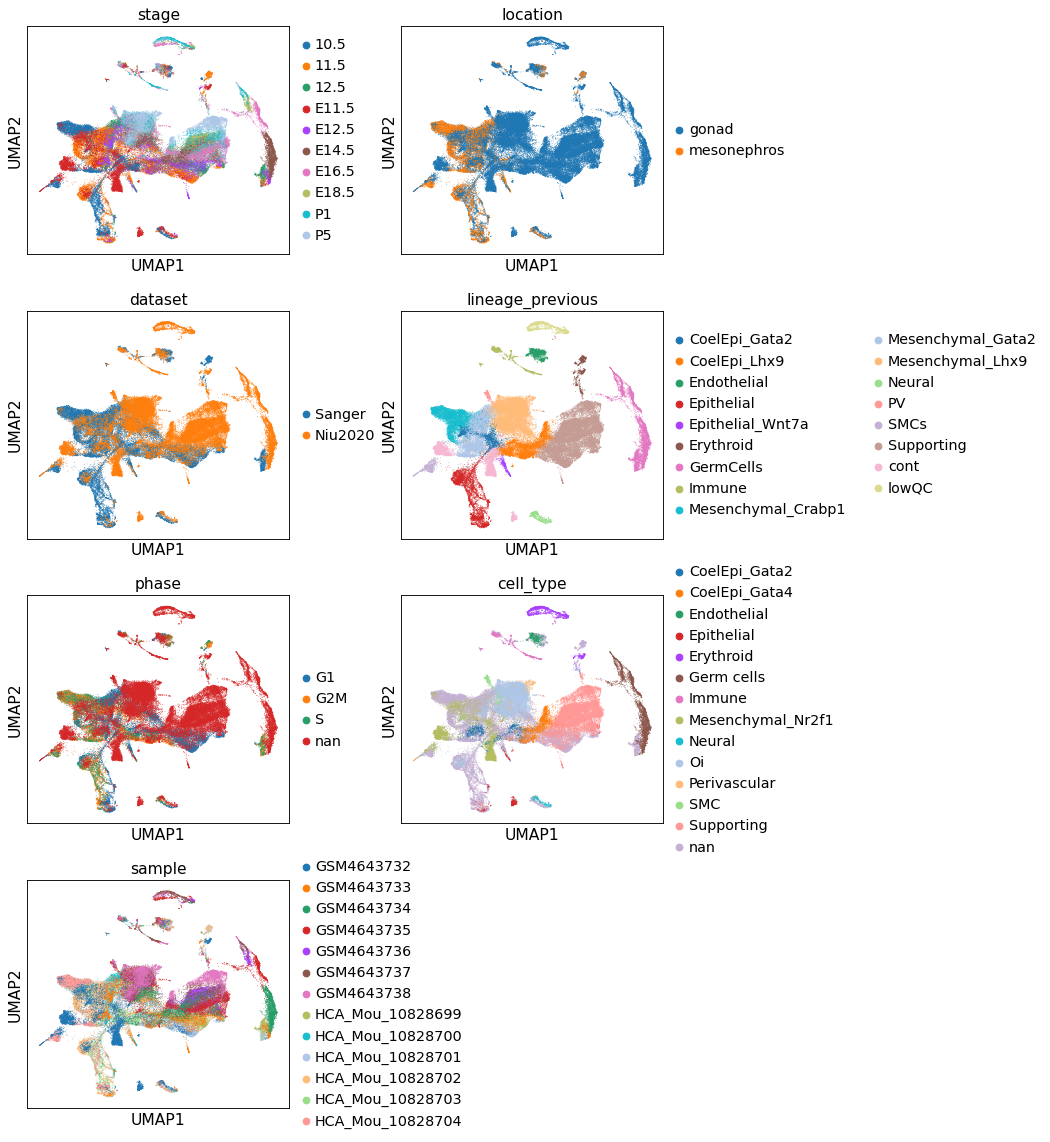

In [15]:
sc.pl.umap(
    adata,
    color=[ "stage", 'location', "dataset", 'lineage_previous', 'phase', 'cell_type', 'sample'], 
    frameon=True, ncols = 2, wspace = 0.3
)

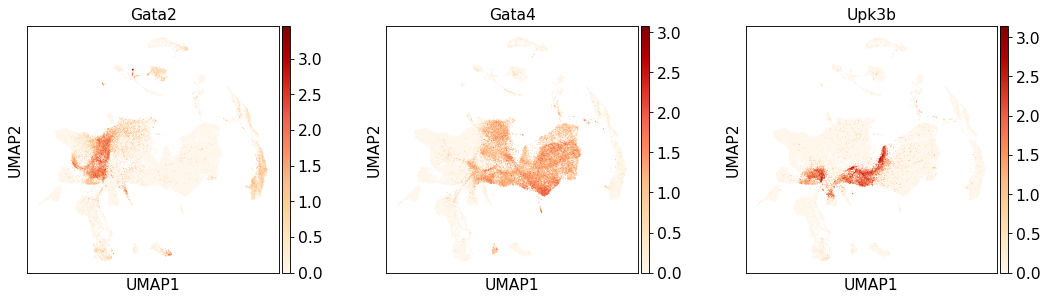

In [16]:
sc.pl.umap(
    adata,
    color=['Gata2',  'Gata4', 'Upk3b'], color_map = "OrRd",
    frameon=True, ncols = 3, wspace = 0.3
)

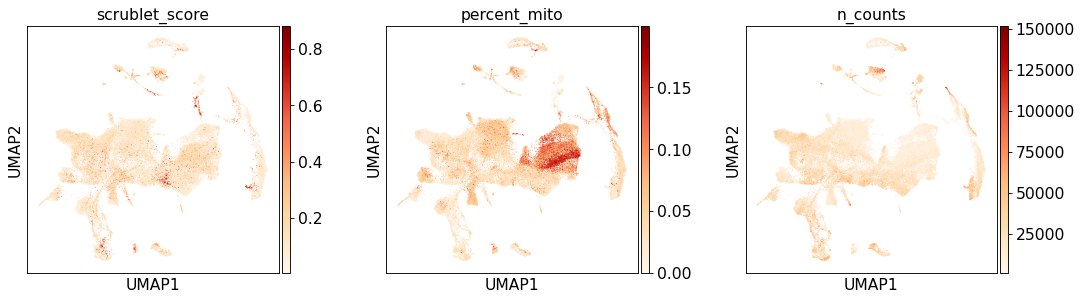

In [17]:
sc.pl.umap(
    adata,
    color=['scrublet_score',  'percent_mito', 'n_counts'], color_map = "OrRd",
    frameon=True, ncols = 3, wspace = 0.3
)

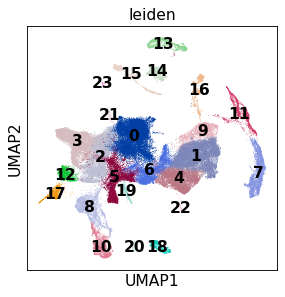

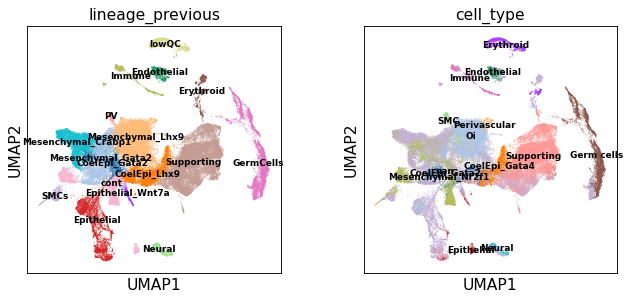

In [18]:
sc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(
    adata,
    color=['leiden'], color_map = "OrRd",legend_loc='on data',
    frameon=True,  wspace = 0.3
)
sc.pl.umap(
    adata,
    color=["lineage_previous", 'cell_type'], ncols = 2,
    legend_loc='on data', legend_fontsize=8
)

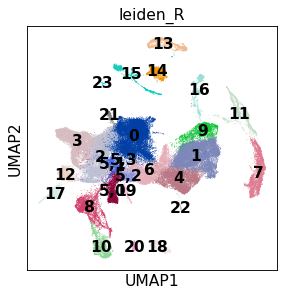

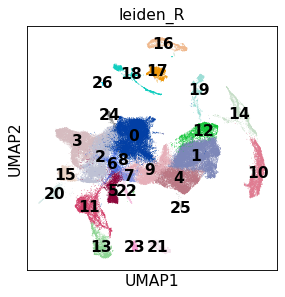

In [20]:
sc.tl.leiden(adata, resolution=0.2, restrict_to=('leiden', ['5']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

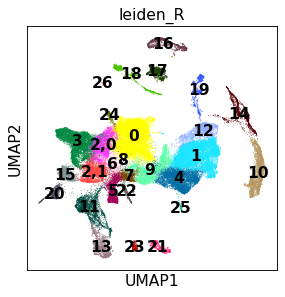

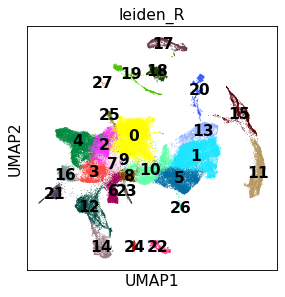

In [36]:
sc.tl.leiden(adata, resolution=0.1, restrict_to=('leiden', ['2']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

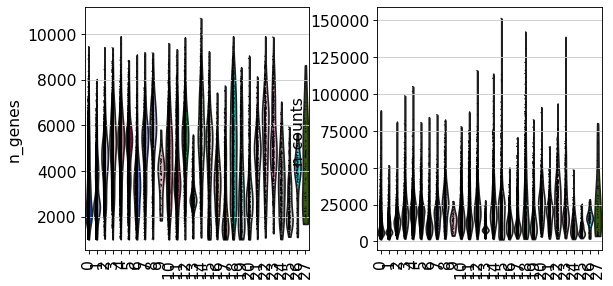

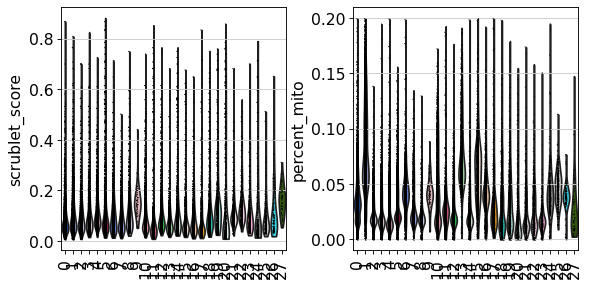

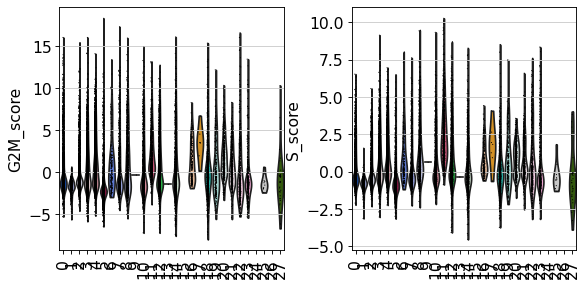

In [37]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], groupby='leiden_R', rotation=90)
sc.pl.violin(adata, ['scrublet_score', 'percent_mito'], groupby='leiden_R', rotation=90)
sc.pl.violin(adata, ['G2M_score', 'S_score'], groupby='leiden_R', rotation=90)

## Markers

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


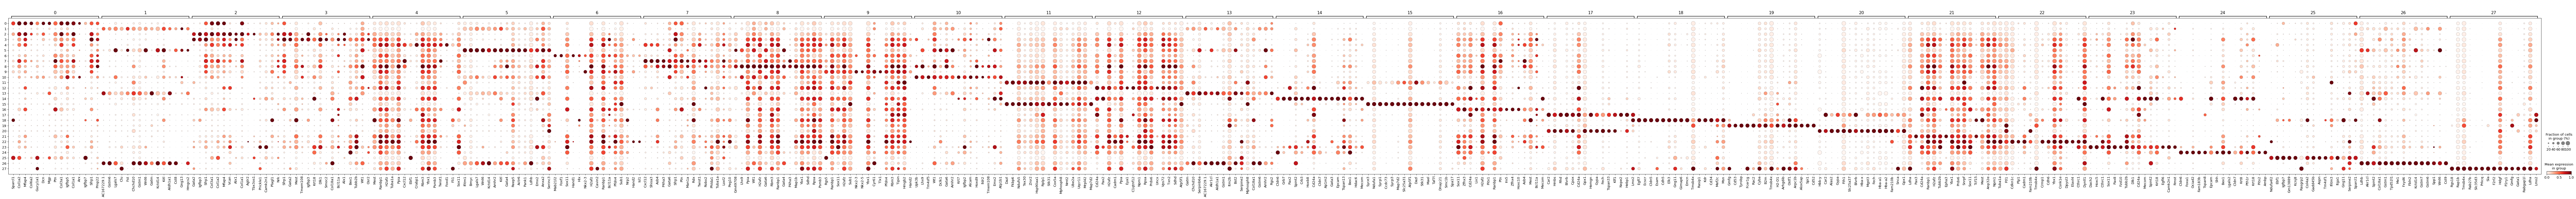

In [38]:
bdata.obs['leiden'] = adata.obs['leiden']
sc.tl.rank_genes_groups(bdata, groupby='leiden', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(bdata, n_genes=15, dendrogram=False, use_raw = False, standard_scale = 'var')

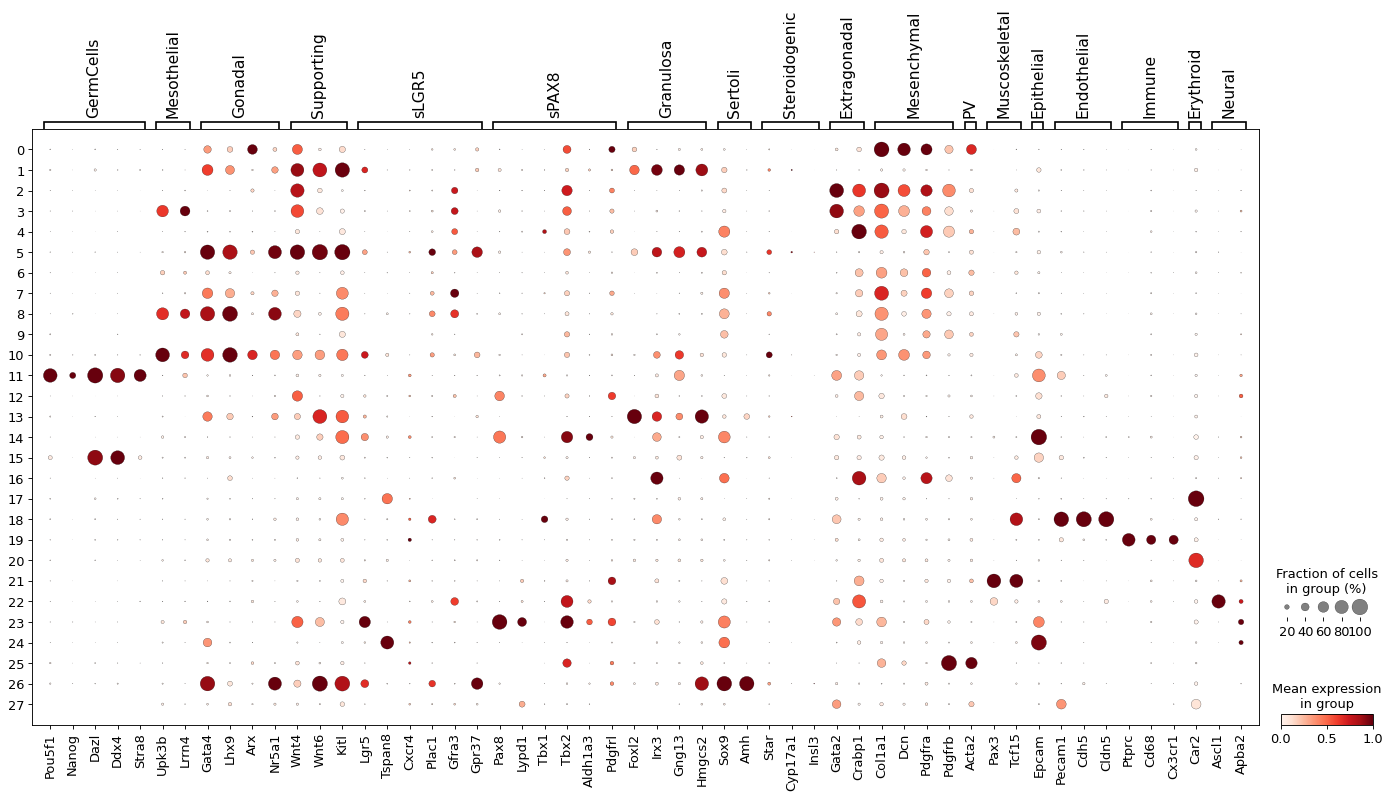

In [35]:
marker_genes = {'GermCells' : ['Pou5f1', 'Nanog', 'Dazl', 'Ddx4', 'Stra8'], 
'Mesothelial' : ['Upk3b', 'Lrrn4'], 
'Gonadal' : ["Gata4", "Lhx9", 'Arx', 'Nr5a1'], 
'Supporting' : ['Wnt4',  'Wnt6',  'Kitl'], 
 'sLGR5' : ['Lgr5', 'Tspan8', 'Cxcr4', 'Plac1', "Gfra3",'Gpr37'],
 'sPAX8' : ['Pax8', 'Lypd1', 'Tbx1', 'Tbx2', 'Aldh1a3', 'Pdgfrl'], 
'Granulosa' : [ 'Foxl2', 'Irx3', 'Gng13','Hmgcs2'], 
 'Sertoli':['Sox9', 'Amh'],
 'Steroidogenic' : ['Star', 'Cyp17a1', 'Insl3'],
 'Extragonadal' : ['Gata2',   'Crabp1'], 
 'Mesenchymal' : ['Col1a1', 'Dcn', 'Pdgfra', 'Pdgfrb'],
 'PV':['Acta2'], 
 'Muscoskeletal':['Pax3', 'Tcf15'],
 'Epithelial' : ['Epcam'], 
 'Endothelial' : ['Pecam1', 'Cdh5', 'Cldn5'],
 'Immune' : ['Ptprc', 'Cd68', 'Cx3cr1'], 
 'Erythroid' : ['Car2'], 
 'Neural' : ['Ascl1', 'Apba2']
}
sc.pl.dotplot(adata, marker_genes, groupby='leiden', use_raw=False, standard_scale = 'var')

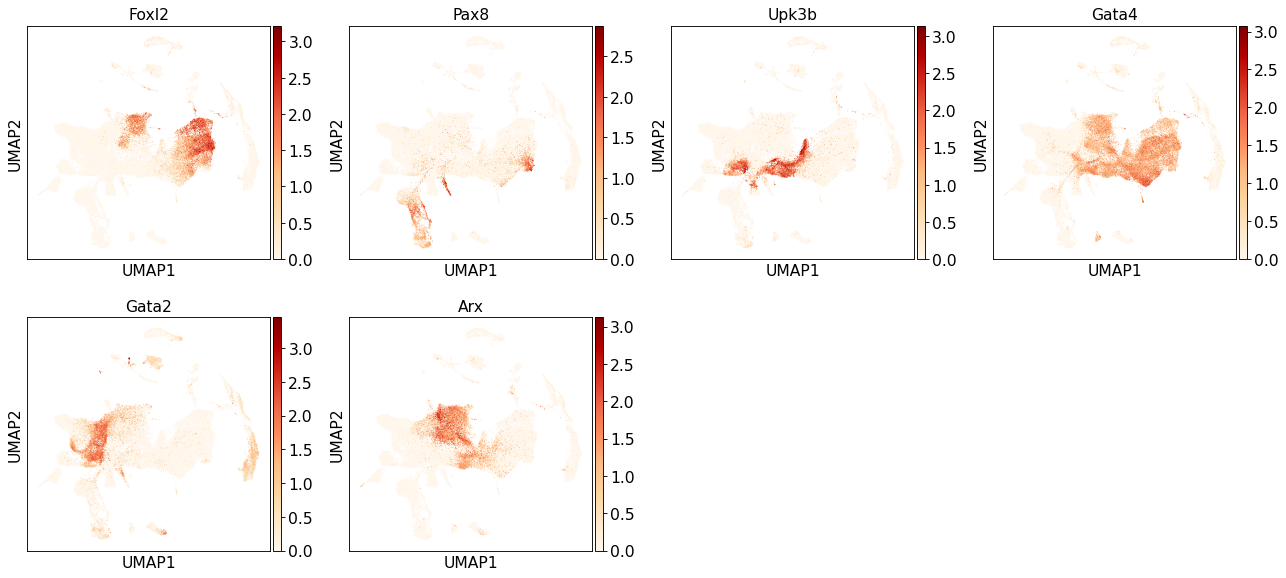

In [27]:
sc.pl.umap(
    adata,
    color=['Foxl2', 'Pax8', 'Upk3b', 'Gata4','Gata2', 'Arx'], color_map = "OrRd")

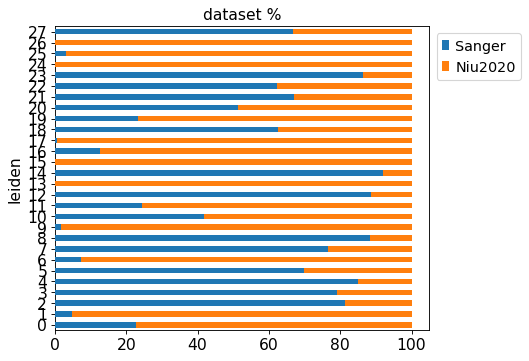

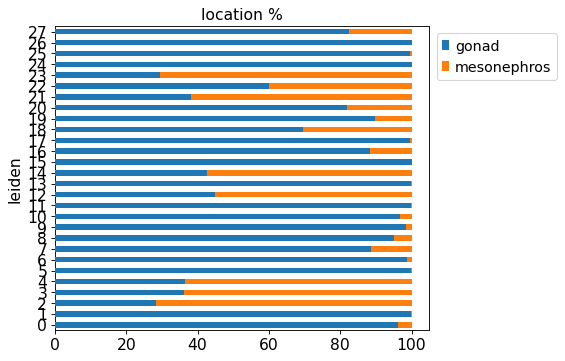

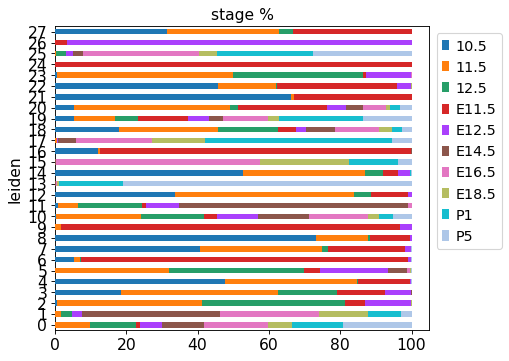

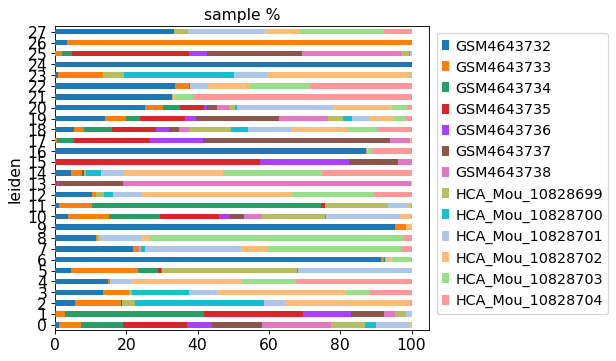

In [28]:
Barplot('dataset', adata, var='leiden', height=5)
Barplot('location', adata, var='leiden', height=5)
Barplot('stage', adata, var='leiden', height=5)
Barplot('sample', adata, var='leiden', height=5)

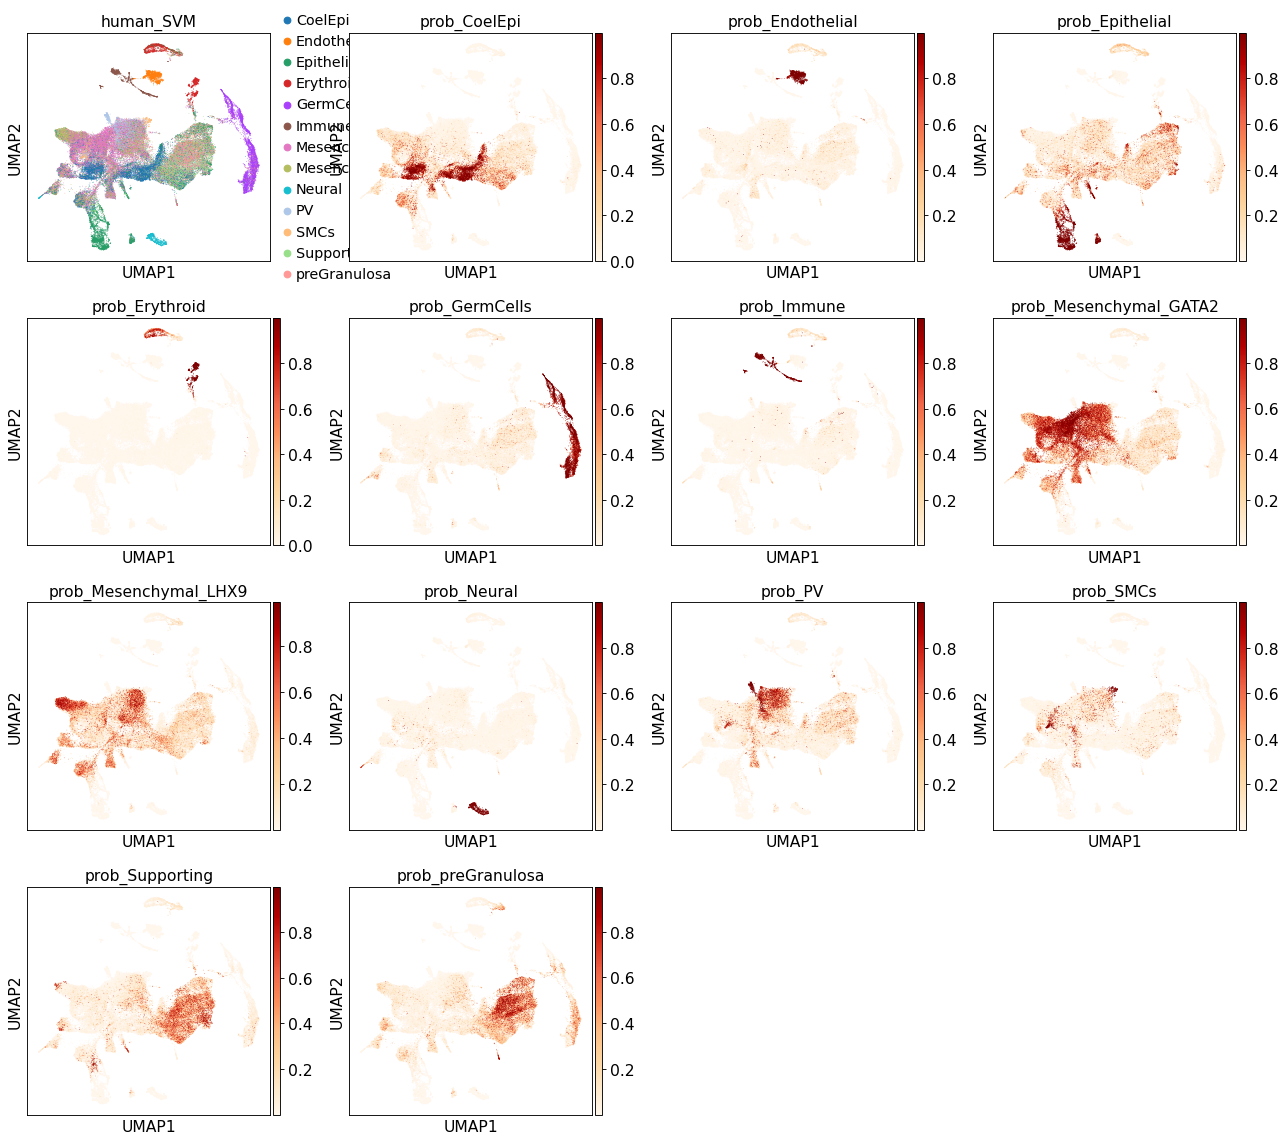

In [25]:
# Plot predictions from SVM
meta = pd.read_csv('/nfs/team292/vl6/Mouse_Sanger/SVM_females_probs.csv')
meta = meta.set_index('Unnamed: 0')
meta.head()

dfnames = meta.columns.tolist()

sc.pl.umap(
    adata,
    color=dfnames, color_map = "OrRd")


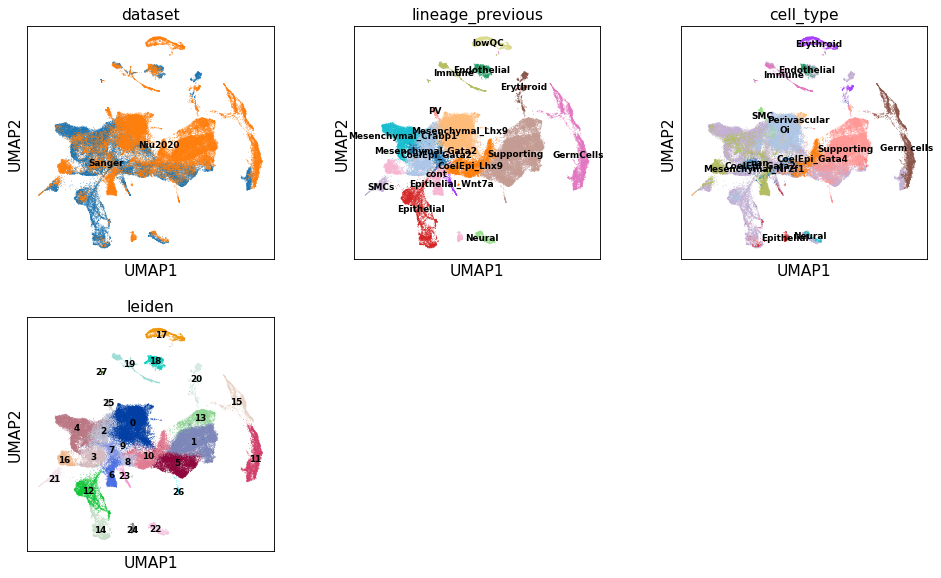

In [26]:
sc.pl.umap(
    adata,
    color=['dataset', "lineage_previous", 'cell_type', 'leiden'], ncols = 3,
    legend_loc='on data', legend_fontsize=8
)

... storing 'lineage' as categorical


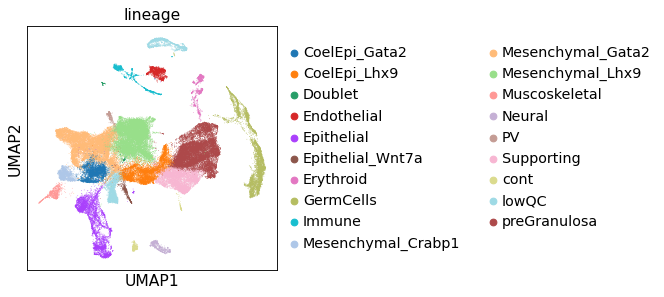

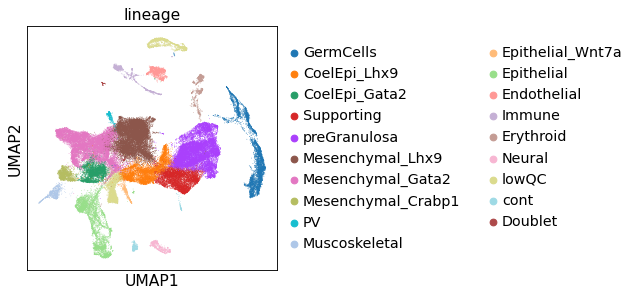

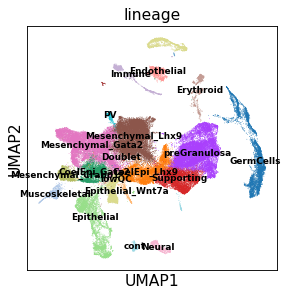

In [27]:
adata.obs['lineage'] = adata.obs['leiden'].tolist()
adata.obs.at[adata.obs['lineage'] == '0', 'lineage'] = 'Mesenchymal_Lhx9'
adata.obs.at[adata.obs['lineage'] == '1', 'lineage'] = 'preGranulosa'
adata.obs.at[adata.obs['lineage'] == '2', 'lineage'] = 'Mesenchymal_Gata2'
adata.obs.at[adata.obs['lineage'] == '3', 'lineage'] = 'CoelEpi_Gata2'
adata.obs.at[adata.obs['lineage'] == '4', 'lineage'] = 'Mesenchymal_Gata2'
adata.obs.at[adata.obs['lineage'] == '5', 'lineage'] = 'Supporting'
adata.obs.at[adata.obs['lineage'] == '6', 'lineage'] = 'lowQC'
adata.obs.at[adata.obs['lineage'] == '7', 'lineage'] = 'Mesenchymal_Gata2'
adata.obs.at[adata.obs['lineage'] == '8', 'lineage'] = 'CoelEpi_Lhx9'
adata.obs.at[adata.obs['lineage'] == '9', 'lineage'] = 'Doublet'
adata.obs.at[adata.obs['lineage'] == '10', 'lineage'] = 'CoelEpi_Lhx9'
adata.obs.at[adata.obs['lineage'] == '11', 'lineage'] = 'GermCells'
adata.obs.at[adata.obs['lineage'] == '12', 'lineage'] = 'Epithelial'
adata.obs.at[adata.obs['lineage'] == '13', 'lineage'] = 'preGranulosa'
adata.obs.at[adata.obs['lineage'] == '14', 'lineage'] = 'Epithelial'
adata.obs.at[adata.obs['lineage'] == '15', 'lineage'] = 'GermCells'
adata.obs.at[adata.obs['lineage'] == '16', 'lineage'] = 'Mesenchymal_Crabp1'
adata.obs.at[adata.obs['lineage'] == '17', 'lineage'] = 'lowQC'
adata.obs.at[adata.obs['lineage'] == '18', 'lineage'] = 'Endothelial'
adata.obs.at[adata.obs['lineage'] == '19', 'lineage'] = 'Immune'
adata.obs.at[adata.obs['lineage'] == '20', 'lineage'] = 'Erythroid'
adata.obs.at[adata.obs['lineage'] == '21', 'lineage'] = 'Muscoskeletal'
adata.obs.at[adata.obs['lineage'] == '22', 'lineage'] = 'Neural'
adata.obs.at[adata.obs['lineage'] == '23', 'lineage'] = 'Epithelial_Wnt7a'
adata.obs.at[adata.obs['lineage'] == '24', 'lineage'] = 'cont'
adata.obs.at[adata.obs['lineage'] == '25', 'lineage'] = 'PV'
adata.obs.at[adata.obs['lineage'] == '26', 'lineage'] = 'cont'
adata.obs.at[adata.obs['lineage'] == '27', 'lineage'] = 'Doublet'
set(adata.obs['lineage'])
sc.pl.umap(adata, color=['lineage'])
adata.obs['lineage'].cat.reorder_categories(['GermCells', 'CoelEpi_Lhx9', 'CoelEpi_Gata2', 'Supporting', 'preGranulosa',
                                             'Mesenchymal_Lhx9', 
                                              'Mesenchymal_Gata2', 'Mesenchymal_Crabp1',  'PV', 'Muscoskeletal',
                                              'Epithelial_Wnt7a',  'Epithelial',
                                               'Endothelial', 'Immune',   'Erythroid', 'Neural',
                                             'lowQC', 'cont', 'Doublet'], inplace=True)


sc.pl.umap(adata, color=['lineage'])
sc.pl.umap(adata, color=['lineage'], ncols = 2, legend_loc='on data', legend_fontsize=8)

# Save visualization

In [28]:
adata.write(path_to_gonads+'mouse-gonads_female.h5ad')
adata.obs.to_csv(path_to_gonads+'/mouse-gonads_females_annotated.csv')

## Examine

In [29]:
sc.pl.dotplot(adata, marker_genes, groupby='lineage', use_raw=False, standard_scale = 'var')

NameError: name 'marker_genes' is not defined

In [ ]:
# bdata.obs['lineage'] = adata.obs['lineage']
sc.tl.rank_genes_groups(adata, groupby='lineage', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, dendrogram=False, use_raw = False, standard_scale = 'var')

In [ ]:
Barplot('dataset', adata, var='lineage', height=4)
Barplot('location', adata, var='lineage', height=4)
Barplot('stage', adata, var='lineage', height=4)